### SEIRC Model Covid-19

*Author*: Simon Frost

*Date*: 2018-07-12

-- http://epirecip.es/epicookbook/chapters/sir/python

Modified for Covid-19 

*Author*: Marcello Perathoner

*Date*: 2020-03-14

## The SEIRC Model

This is a SEIR Model extended by a C compartment for Critically ill people, that is people that need intensive care in a hospital.  A fixed percentile of I becomes C and then stays C for a fixed length of time.

In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import ode, solve_ivp

In [2]:
def seirc_ode (times, init, parms):
    α, β, γ, c1, c2, N = parms
    S, E, I, R, C      = init
    # ODEs (ordinary differential equations)
    F = β * I / N
    dS = -F * S
    dE = F * S - α * E
    dI = α * E - γ * I
    dR = γ * I
    dC = c1 * α * E - c2 * C
    return [dS, dE, dI, dR, dC]

## The Basic Reproduction Number

In epidemiology, the basic reproduction number (sometimes called basic reproductive ratio, or incorrectly basic reproductive rate, and denoted R0, pronounced R nought or R zero) of an infection can be thought of as the expected number of cases directly generated by one case in a population where all individuals are susceptible to infection. -- https://en.wikipedia.org/wiki/Basic_reproduction_number

The R0 of Covid-19 is estimated as: 1.4 – 3.9

R0 = β * γ

In [3]:
N = 83019213      # Germany: Population 31.12.2018
S = 4838          # Germany: Confirmed Covid-19 cases 16.03.2020

α = 2    # How many days before E(xposed) becomes I(nfectious)
β = 0.2  # How many people does an I infect each day on average
γ = 7    # How many days an I stays infectious on average

c1 = 0.0165 # How many I become C(ritical)
c2 = 28     # How many days a C occupies a bed
c3 = 5600   # How many beds thare are (28000 * 20% free)

oversample = 10 # how many iterations per simulated day
parms = [1 / α, β, 1 / γ, c1, 1 / c2, N] 
init  = [N - S, S, 0, 0, 0]     # S, E, I, R, C
times = np.linspace (0, 365, 365 * oversample + 1)

In [4]:
sol = solve_ivp (fun=lambda t, y: seirc_ode(t, y, parms), t_span=[min(times),max(times)], y0=init, t_eval=times)

seir_out = pd.DataFrame({"t":sol["t"],"S":sol["y"][0],"E":sol["y"][1],"I":sol["y"][2],"R":sol["y"][3],"C":sol["y"][4]})

#### Visualisation

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

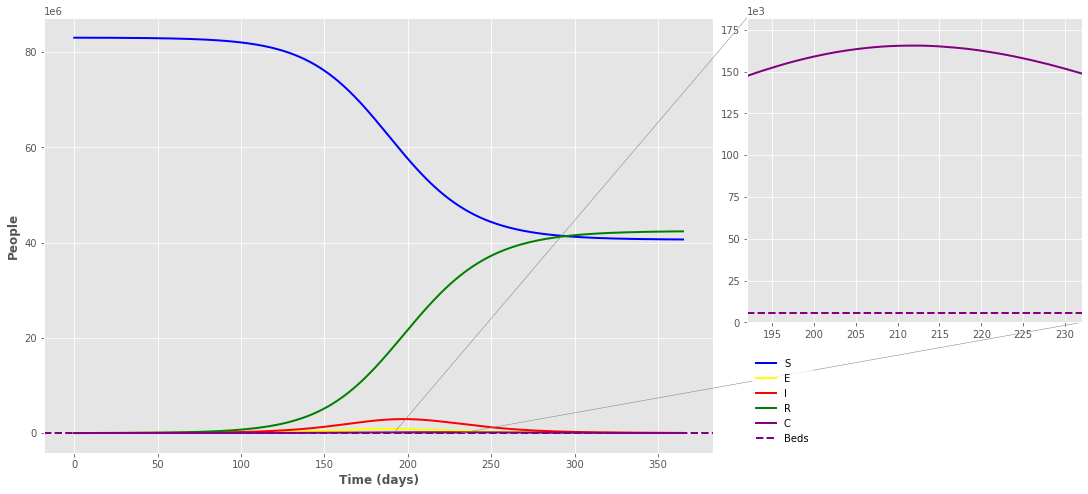

In [6]:
plt.style.use("ggplot")

fig, ax = plt.subplots (figsize=(12, 8))

def plot_it (ax):
    sline = ax.plot("t","S","", data=seir_out, color="blue",   linewidth=2)
    eline = ax.plot("t","E","", data=seir_out, color="yellow", linewidth=2)
    iline = ax.plot("t","I","", data=seir_out, color="red",    linewidth=2)
    rline = ax.plot("t","R","", data=seir_out, color="green",  linewidth=2)
    cline = ax.plot("t","C","", data=seir_out, color="purple", linewidth=2)
    hline = ax.axhline (y = c3, label="Beds", color='purple', linewidth=2, linestyle='--')

ax.ticklabel_format (axis="y", style="sci", scilimits = (6, 6))
plot_it (ax)

plt.xlabel ("Time (days)",   fontweight="bold")
plt.ylabel ("People", fontweight="bold")
legend = ax.legend (loc="lower left",bbox_to_anchor=(1.05,0.0))
frame = legend.get_frame()
frame.set_facecolor ("white")
frame.set_linewidth (0)

# the zoomed subplot
outmax = seir_out.max (axis=0)
idxmax = seir_out.idxmax (axis=0) / oversample # where are the maxima
axins = ax.inset_axes ([1.05, 0.3, 0.5, 0.7])
axins.ticklabel_format (axis="y", style="sci", scilimits = (3, 3))
plot_it (axins)
axins.set_xlim (idxmax.C - 20, idxmax.C + 20) # zoom around maximum
axins.set_ylim (0, outmax.C * 1.1)            # scale to maximum
inset = mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
